Copyright 2021 Takehiro Ajioka

### Enviroment

Python 3.6
Anaconda
pytorch==1.9.0_cuda11.1
fastai==2.5.2
tifffile==2020.9.3
opencv-python==4.5.3.56
efficientnet-pytorch==0.7.1
tqdm==4.47.0

# EfficientNetB0 ＋ GRU

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
RNN_Type = 'GRU'
CNN_fix = 'nonFix' #'nonFix'
SEQ_SIZE = 5 # input frame number [-n,n+1]

In [3]:
# Data allocation (Mouse #)
TRAIN = [3,4,5]
VALID = [1]
TEST = [2]

In [4]:
TRAIN = f'[{TRAIN[0]}{TRAIN[1]}{TRAIN[2]}]'
VALID = VALID[0]
TEST = TEST[0]

In [5]:
print(TRAIN)
print(VALID)
print(TEST)

[345]
1
2


# Training

## Model

In [6]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [7]:
# Random seed
import os, random
SEED = 2021

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms = True
    torch.backends.cudnn.deterministic = True

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_everything(SEED)
generator = torch.Generator()
generator.manual_seed(SEED)

In [8]:
VER = 'b0'
from efficientnet_pytorch import EfficientNet
cnn = EfficientNet.from_pretrained('efficientnet-'+VER, num_classes=1)

Loaded pretrained weights for efficientnet-b0


In [9]:
cnn.load_state_dict(torch.load(f'./stage1_model/model_EfficientNet{VER}_valid{VALID}_test{TEST}.pth'))

<All keys matched successfully>

In [10]:
FEATURE_SIZE = 1280 # efficient-net b0の時は1280
RNN_UNITS = 128

if RNN_Type == 'RNN':
    rnn = nn.RNN(FEATURE_SIZE, RNN_UNITS, num_layers=2, dropout=0.2, batch_first=True)
elif RNN_Type == 'LSTM':
    rnn = nn.LSTM(FEATURE_SIZE, RNN_UNITS, num_layers=2, dropout=0.2, batch_first=True)
elif RNN_Type == 'GRU':
    rnn = nn.GRU(FEATURE_SIZE, RNN_UNITS, num_layers=2, dropout=0.2, batch_first=True)

In [11]:
# Model
class CNN_RNN(nn.Module):
    def __init__(self,cnn):
        super(CNN_RNN, self).__init__()
        self.cnn = cnn
        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        self.rnn = rnn
        self.linear_out = nn.Linear(RNN_UNITS, 1)

    def forward(self, x):
        x = x.reshape(-1, 3, x.shape[3], x.shape[4]) # (batch, channel, size1, size2)
        x = self.cnn.extract_features(x)
        x = self.avgpool(x)
        x = x.reshape(-1, 2*SEQ_SIZE+1, FEATURE_SIZE) # (batch, seq_len, input_size)
        self.rnn.flatten_parameters()
        o_rnn, _ = self.rnn(x)
        output = self.linear_out(o_rnn[:,-1,:])
        return output

In [12]:
model = CNN_RNN(cnn).cuda()

In [13]:
# Fix the parameters of CNN
if CNN_fix == 'Fix':
    BATCH_SIZE = 256
    print(f'Batch size: {BATCH_SIZE}')
    for param in cnn.parameters():
        param.requires_grad = False
elif CNN_fix == 'nonFix':
    BATCH_SIZE = 64
    print(f'Batch size: {BATCH_SIZE}')

Batch size: 64


In [14]:
# Count number of parameters
params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()
print(params) 

4649470


## Learning

In [15]:
df = pd.read_csv('./data_64_5mice.csv')
df

,Data_ID,Mouse_#
0,20180125_Emx1G6_LR_1,1
1,20180125_Emx1G6_R_1,3
2,20180125_Emx1G6_non_1,2
3,20180126_Emx1G6_LR_1,1
4,20180126_Emx1G6_R_1,3
...,...,...
59,20180411_Emx1G6_non_1,5
60,20180412_Emx1G6_L_1,4
61,20180412_Emx1G6_non_1,5
62,20180413_Emx1G6_L_1,4


In [16]:
# parameter fof normalizing
mean_dict = {}
std_dict = {}
save_path = './mean_and_std/'

for i in df['Data_ID']:
    m = np.load(save_path + i + '_mean.npy')
    s = np.load(save_path + i + '_std.npy')
    mean_dict[i] = m
    std_dict[i] = s

In [17]:
import glob
import re

In [18]:
# exclude frame number
def calc_exc_num(i):
    f_list = glob.glob(i + '*.npz')
    L = len(f_list)
    print(f'frame number: {L}')
    exc_num = list(range(SEQ_SIZE)) + list(range(L-SEQ_SIZE,L))
    return exc_num

In [19]:
# input file list
def input_list(MODE):
    folder = glob.glob(f'./npz_data/{MODE}/*_0.npz')
    exp_path = [folder[i].rstrip('_0.npz') for i in range(len(folder))]
    exclude_list = []
    for i in exp_path:
        exc_num = calc_exc_num(i)
        for n in exc_num:
            npz_path = i + '_' + str(n) + '.npz'
            exclude_list.append(npz_path)
    f_list = glob.glob(f'./npz_data/{MODE}/*.npz')
    input_list = [i for i in f_list if i not in exclude_list]
    return input_list

In [20]:
# Dataset
class ImageLoadDataset:
    def __init__(self, filelist):
        self.files = filelist
        
    def __len__(self):
        return (len(self.files))
    
    def __getitem__(self, idx):
        npz_path = self.files[idx]
        xy_data = np.load(npz_path)
        experiment_name = npz_path[len('./npz_data/1/'):-len(re.search('_\d+.npz',npz_path).group())]
        mean = mean_dict[experiment_name]
        std = std_dict[experiment_name]
        ax = xy_data['image'].shape
        num = re.search('_\d+.npz', npz_path).group().lstrip('_').rstrip('.npz') # frame number
        X = np.zeros([2*SEQ_SIZE+1, ax[0], ax[1], ax[2]])
        for idx, i in enumerate(range(int(num) - SEQ_SIZE, int(num) + SEQ_SIZE + 1)):
            length = len(num) + len('_.npz')
            path = npz_path[:-length] + '_' + str(i) + '.npz'
            xy_data2 = np.load(path)
            X[idx,:,:,:] = (xy_data2['image'] - mean) / std # Normalize
        x = torch.tensor(X, dtype=torch.float)
        y = torch.tensor(xy_data['label'], dtype=torch.float)      
        return x, y

In [21]:
# Dataset setting
from fastai.data.core import DataLoaders
ds_train = ImageLoadDataset(input_list(TRAIN))
ds_valid = ImageLoadDataset(input_list(VALID))
dls = DataLoaders.from_dsets(ds_train, ds_valid, bs=BATCH_SIZE, shuffle=True,
        num_workers=10, pin_memory=True, worker_init_fn=seed_worker, generator=generator).cuda()

frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998
frame number: 17998


In [22]:
# Learn setting
from fastai.vision.all import Learner, ShowGraphCallback, SaveModelCallback
loss = nn.BCEWithLogitsLoss()
learn = Learner(dls, model, loss_func=loss).to_fp16() # Mixed precision
callbacks = [SaveModelCallback(monitor='valid_loss', comp=np.less), ShowGraphCallback()]

epoch,train_loss,valid_loss,time
0,0.098566,0.431049,1:09:20
1,0.058709,0.656831,1:09:08
2,0.034378,0.763120,1:08:58


Better model found at epoch 0 with valid_loss value: 0.43104881048202515.


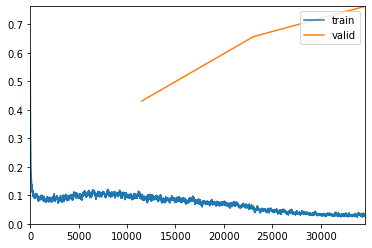

In [23]:
# Training
Epoch = 3
learn.fit_one_cycle(Epoch, lr_max=1e-3, cbs=callbacks)

In [24]:
# Save model
torch.save(learn.model.state_dict(),f'./stage2_model/model_EfficientNet{VER}_{RNN_Type}_valid{VALID}_test{TEST}.pth')

# Inference

In [25]:
# Load model
learn.model.load_state_dict(torch.load(f'./stage2_model/model_EfficientNet{VER}_{RNN_Type}_valid{VALID}_test{TEST}.pth'))

<All keys matched successfully>

In [26]:
BATCH_SIZE = 64

In [27]:
from tqdm.auto import tqdm
import gc

def inference_1_image(file_path):
    Y_pred = np.zeros([len(file_path), 1])
    Y_true = np.zeros([len(file_path), 1])
    ds_i = ImageLoadDataset(file_path)
    infe = DataLoader(ds_i, batch_size=BATCH_SIZE, shuffle=False, num_workers=10, pin_memory=True)
    tqdm_loader = tqdm(infe)
    for idx, (imgs,labels) in enumerate(tqdm_loader):
        bs = labels.shape[0]
        Y_pred[idx*BATCH_SIZE:idx*BATCH_SIZE+bs] = torch.sigmoid(learn.model(imgs.cuda())).cpu().detach().numpy()
        Y_true[idx*BATCH_SIZE:idx*BATCH_SIZE+bs] = labels
    del ds_i, infe, tqdm_loader
    gc.collect();
    return Y_pred, Y_true

In [28]:
test_folder = glob.glob(f'./npz_data/{TEST}/*_0.npz')
exp_path = [test_folder[i].rstrip('_0.npz') for i in range(len(test_folder))]
print(exp_path)

['./npz_data/2/20180215_Emx1G6_non_1', './npz_data/2/20180216_Emx1G6_non_1', './npz_data/2/20180213_Emx1G6_non_1', './npz_data/2/20180209_Emx1G6_non_1', './npz_data/2/20180126_Emx1G6_non_1', './npz_data/2/20180131_Emx1G6_non_1', './npz_data/2/20180125_Emx1G6_non_1', './npz_data/2/20180205_Emx1G6_non_1', './npz_data/2/20180201_Emx1G6_non_1', './npz_data/2/20180129_Emx1G6_non_1', './npz_data/2/20180214_Emx1G6_non_1', './npz_data/2/20180130_Emx1G6_non_1']


In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

def calculate_accuracy(exp_paths):
    Y_pred_all = []
    Y_true_all = []
    acc = np.zeros(len(exp_paths))
    for i, exp_path in enumerate(exp_paths):
        print(exp_path)
        files = glob.glob(exp_path + '*.npz')
        print(f'frame number: {len(files)}')
        Y_pred, Y_true = inference_1_image([exp_path + f'_{i}.npz' for i in range(SEQ_SIZE, len(files) - SEQ_SIZE)])
        Y_pred_all.append(Y_pred)
        Y_true_all.append(Y_true)
        output = Y_pred > 0.5
        accuracy = (output == Y_true).mean()
        print('Accuracy: {}'.format(accuracy))
        AUC = roc_auc_score(Y_true, Y_pred)
        print(f'AUC: {AUC}')
        acc[i] = accuracy
    print('Mean Accuracy: {}'.format(acc.mean()))
    return Y_pred_all, Y_true_all

In [30]:
Y_pred, Y_true = calculate_accuracy(exp_path)

./npz_data/2/20180215_Emx1G6_non_1
frame number: 17998



Accuracy: 0.7800756059595286
AUC: 0.9680216465343009
./npz_data/2/20180216_Emx1G6_non_1
frame number: 17998



Accuracy: 0.731320880587058
AUC: 0.9414612434829789
./npz_data/2/20180213_Emx1G6_non_1
frame number: 17998



Accuracy: 0.9467978652434956
AUC: 0.8322223750617093
./npz_data/2/20180209_Emx1G6_non_1
frame number: 17998



Accuracy: 0.8813097620635979
AUC: 0.9552253554616136
./npz_data/2/20180126_Emx1G6_non_1
frame number: 17998



Accuracy: 0.7172559484100511
AUC: 0.917935055618509
./npz_data/2/20180131_Emx1G6_non_1
frame number: 17998



Accuracy: 0.9441294196130754
AUC: 0.9212122752163417
./npz_data/2/20180125_Emx1G6_non_1
frame number: 17998



Accuracy: 0.8383366688903714
AUC: 0.9303665232374505
./npz_data/2/20180205_Emx1G6_non_1
frame number: 17998



Accuracy: 0.9347898599066043
AUC: 0.9733009149854338
./npz_data/2/20180201_Emx1G6_non_1
frame number: 17998



Accuracy: 0.9485212363798088
AUC: 0.9797686718147085
./npz_data/2/20180129_Emx1G6_non_1
frame number: 17998



Accuracy: 0.7378252168112075
AUC: 0.9287418819293508
./npz_data/2/20180214_Emx1G6_non_1
frame number: 17998



Accuracy: 0.9429063820324661
AUC: 0.9618402389288717
./npz_data/2/20180130_Emx1G6_non_1
frame number: 17998



Accuracy: 0.9088837002446075
AUC: 0.9134535202312545
Mean Accuracy: 0.8593460455118228


In [31]:
# Save test result
from scipy import io
io.savemat(f"./result/test_result_EfficientNet{VER}_{RNN_Type}_valid{VALID}_test{TEST}.mat", {"test_label":Y_true, "test_pred":Y_pred})

In [32]:
# Plot ROC curve
def plot_roc(y_pred, y_test, mode):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    AUC = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
    plt.title(mode + " ROC curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    print('AUC: {:.3f}'.format(AUC))
    opt_thr = thresholds[np.argmax(tpr - fpr)]
    print('Optimal threshold: {:.3f}'.format(opt_thr))

In [33]:
test_pred = np.vstack(Y_pred)
test_true = np.vstack(Y_true)

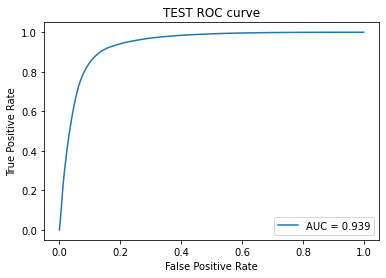

AUC: 0.939
Optimal threshold: 0.925


In [34]:
plot_roc(test_pred, test_true, "TEST")